# Matthieu Cazier


Vous êtes Data Scientist dans une très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents

Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire

Vous êtes donc chargé de développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension

#### librairies

In [1]:
import findspark
findspark.init()

import pyspark
import random
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from pyspark.context import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline


import warnings
warnings.filterwarnings('ignore')

###### Récupérer le fichier code

In [2]:
with open('cle.txt','r') as b:
        msg = b.read()
ID= str(msg).split('\n')[0]
KEY= msg.split('\n')[1]
os.environ["AWS_ACCESS_KEY_ID"]=ID
os.environ["AWS_SECRET_ACCESS_KEY"]=KEY

###### Configuration

In [3]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell'

In [4]:
os.environ['PYSPARK_PYTHON']

'/home/ubuntu/anaconda3/envs/matt/bin/python'

In [5]:
print('PYSPARK_PYTHON ', os.environ['PYSPARK_PYTHON'])

PYSPARK_PYTHON  /home/ubuntu/anaconda3/envs/matt/bin/python


In [6]:
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/matthieu/anaconda3/envs/new/bin/python'

In [7]:
print('PYSPARK_DRIVER_PYTHON ', os.environ['PYSPARK_DRIVER_PYTHON'])

PYSPARK_DRIVER_PYTHON  /home/matthieu/anaconda3/envs/new/bin/python


In [8]:
os.environ["AWS_ACCESS_KEY_ID"]=ID
os.environ["AWS_SECRET_ACCESS_KEY"]=KEY

In [9]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf

In [10]:
conf = (SparkConf().set('spark.executor.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true').set('spark.driver.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true'))

In [11]:
scT=SparkContext(conf=conf)
scT.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')

In [12]:
hadoopConf = scT._jsc.hadoopConfiguration()
hadoopConf.set('fs.s3a.awsAccessKeyId', ID)
hadoopConf.set('fs.s3a.awsSecretAccessKey', KEY)
hadoopConf.set('fs.s3a.endpoint', 's3-us-east-2.amazonaws.com')
hadoopConf.set('com.amazonaws.services.s3a.enableV4', 'true')
hadoopConf.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')

In [13]:
sql = SparkSession(scT)

###### Récupérer les images depuis S3

In [14]:
path = 's3a://monbucketoc/Réduit/*'

In [15]:
image_df = ImageSchema.readImages(path)

In [16]:
image_df.show()

+--------------------+
|               image|
+--------------------+
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
|[s3a://monbucketo...|
+--------------------+



(100, 100, 3)


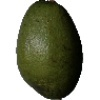

In [17]:
première = image_df.first()
visu = np.array(première.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1]
print(visu.shape)
Image.fromarray(visu, 'RGB')

###### Réduction de dimension

In [18]:
from sparkdl import DeepImageFeaturizer

Using TensorFlow backend.


In [19]:
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="image_preprocessed", modelName="ResNet50")

In [20]:
p = Pipeline(stages=[featurizer])
model = p.fit(image_df)    

In [21]:
df = model.transform(image_df)

In [22]:
#df.show()

#### PCA

Text(0, 0.5, 'cumulative explained variance')

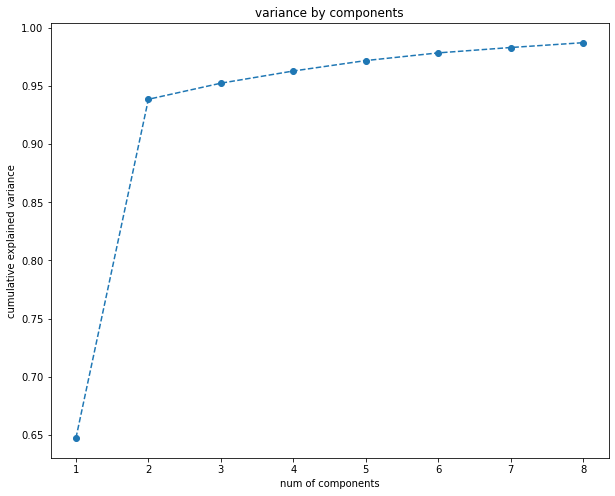

In [23]:
df_pca = df.select('image_preprocessed')
pca = PCA(k=8, inputCol="image_preprocessed", outputCol="pcaFeatures")
model = pca.fit(df_pca)
#print(model.explainedVariance)
cumValues = model.explainedVariance.cumsum()

plt.figure(figsize=(10,8))
plt.plot(range(1,9), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')

In [24]:
df_pca = df.select('image_preprocessed')
pca = PCA(k=2, inputCol="image_preprocessed", outputCol="pcaFeatures")
model = pca.fit(df_pca)
result = model.transform(df_pca).select("pcaFeatures")
result.show(truncate=False)

+----------------------------------------+
|pcaFeatures                             |
+----------------------------------------+
|[2.5235464652659614,-18.83287510883131] |
|[3.9139246370409504,-17.396936195101283]|
|[2.3482782642822255,-18.653477834483017]|
|[2.3624141473883125,-17.026283925176642]|
|[3.554335674967028,-18.84888138130125]  |
|[-26.448336881253873,2.1654263907733777]|
|[-28.059739037893355,2.4337331992586355]|
|[-27.15372157229625,2.490231157289669]  |
|[-26.62019286361941,1.4676170962293311] |
|[-25.90904197816549,1.6764405607408706] |
|[14.234741883799355,9.325318279551988]  |
|[14.661132764807864,9.318818838534192]  |
|[14.325419784185465,9.58713327184732]   |
|[13.459186001101047,8.705566841982526]  |
|[14.068618778302177,9.24333801950826]   |
+----------------------------------------+



#### Regarder l'organisation du df

In [25]:
#df.printSchema()

In [26]:
#df.show()

###### Récupérer le chemin des images

In [27]:
df = df.select('image.origin','image_preprocessed')

In [28]:
#df.show()

###### obtenir la catégorie

In [29]:
split_col = pyspark.sql.functions.split(df['origin'], 'Réduit/')    ## changer Réduit par Training ou Test (pour les autres)
df = df.withColumn('labels', split_col.getItem(1))

In [30]:
split_col = pyspark.sql.functions.split(df['labels'], '/')
df = df.withColumn('labels', split_col.getItem(0))

In [31]:
#df.show()

###### Mettre dans l'ordre

In [32]:
df = df.withColumnRenamed("origin", "path")

In [33]:
df = df.select('path','labels','image_preprocessed')

In [35]:
df.show()

+--------------------+---------+--------------------+
|                path|   labels|  image_preprocessed|
+--------------------+---------+--------------------+
|s3a://monbucketoc...|  Avocado|[0.75997018814086...|
|s3a://monbucketoc...|  Avocado|[0.49009233713150...|
|s3a://monbucketoc...|  Avocado|[0.72865718603134...|
|s3a://monbucketoc...|  Avocado|[0.51640260219573...|
|s3a://monbucketoc...|  Avocado|[0.48175674676895...|
|s3a://monbucketoc...|   Banana|[0.87978106737136...|
|s3a://monbucketoc...|   Banana|[0.81136143207550...|
|s3a://monbucketoc...|   Banana|[0.88818049430847...|
|s3a://monbucketoc...|   Banana|[0.60697412490844...|
|s3a://monbucketoc...|   Banana|[0.73288387060165...|
|s3a://monbucketoc...|Blueberry|[0.23815652728080...|
|s3a://monbucketoc...|Blueberry|[0.12992787361145...|
|s3a://monbucketoc...|Blueberry|[0.19024115800857...|
|s3a://monbucketoc...|Blueberry|[0.11426852643489...|
|s3a://monbucketoc...|Blueberry|[0.13309282064437...|
+--------------------+------

#### Enregistre le df en format parquet directement sur S3

In [69]:
df.write.parquet("s3a://monbucketoc/dataframe")

In [ ]:
### test avec de plus de données
### memoire au drivers